In [15]:
from pymatgen.electronic_structure.dos import CompleteDos
from pymatgen.io.vasp.outputs import Vasprun
from pymatgen.electronic_structure.plotter import DosPlotter, BSDOSPlotter
from pymatgen.electronic_structure.core import Spin
from pymatgen.electronic_structure.plotter import BSPlotter

import numpy as np
from matplotlib import pyplot as plt

In [16]:
dftu = False

if dftu == False:
    path_bands = '../VASP/2.2-bandstructure/output/'
    path_dos = '../VASP/2.1-DOS/output/'
else:
    path_bands = '../VASP/3.2-DFT+U_bandstructure/output/'
    path_dos = '../VASP/3.1-DFT+U_DOS/output/'
path_kpoints = './output_Ti39_sv/KPOINTS'

In [17]:
vasprun_dos = Vasprun(path_dos + 'vasprun.xml')

/usr/local/lib/python3.10/dist-packages/pymatgen/io/vasp/inputs.py:1737: UserWarning: Ignoring unknown variable type SHA256
  warnings.warn(f"Ignoring unknown variable type {key}")
/usr/local/lib/python3.10/dist-packages/pymatgen/io/vasp/inputs.py:1737: UserWarning: Ignoring unknown variable type COPYR
  warnings.warn(f"Ignoring unknown variable type {key}")
/usr/local/lib/python3.10/dist-packages/pymatgen/io/vasp/inputs.py:1822: UnknownPotcarWarning: POTCAR with symbol O_s has metadata that does not match                          any VASP POTCAR known to pymatgen. The data in this                          POTCAR is known to match the following functionals:                          ['PBE_54', 'unvie_PBE_52', 'PBE_52']
  warnings.warn(


In [18]:
dos = vasprun_dos.complete_dos
total_dos = vasprun_dos.tdos

energies = total_dos.energies

In [19]:
vasprun_bands = Vasprun(path_bands + 'vasprun.xml')

In [20]:
bands = vasprun_bands.get_band_structure(kpoints_filename=path_kpoints, line_mode=True)

kpoints_labels = bands.branches 

In [31]:
bands.get_band_gap()

{'direct': True, 'energy': 1.8343999999999996, 'transition': 'GAMMA-GAMMA'}

In [21]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

text_width = 418.25368

# Using seaborn's style
plt.style.use('default')

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}

plt.rcParams.update(tex_fonts)

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

In [22]:
all_bands = bands.bands[Spin(1)]
total_density = total_dos.densities[Spin(1)]
efermi = bands.efermi

cbands = []
vbands = []

for band in all_bands:
    if np.all(band < efermi - 0.5) and np.all(band - efermi > -6):
        vbands.append(band)
    elif np.all(band > efermi + 0.5):
        cbands.append(band)

cbands = np.array(cbands).T
vbands = np.array(vbands).T

top_vband = np.max(vbands, axis=1)
bottom_vband = np.min(vbands, axis=1)
bottom_cband = np.min(cbands, axis=1)
top_cband = np.max(cbands, axis=1)

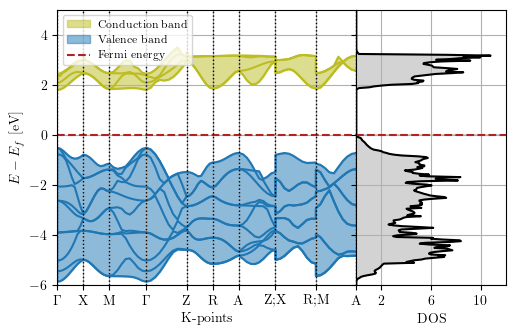

In [29]:
labels = [r'$\Gamma$', 'X', 'M', r'$\Gamma$', 'Z', 'R', 'A', 'Z;X' ,'R;M', 'A']
gap = 10
slice = np.arange(0, (len(labels)-1)*gap, gap)
slice = np.append(slice, [-1])
kpoints = np.array(bands.distance)[slice]

fig_size = set_size(text_width, 1)

fig = plt.figure(figsize=fig_size)
ax_bs, ax_dos = fig.subplots(1,2, sharey=True, gridspec_kw={'width_ratios': [2, 1]})
fig.subplots_adjust(wspace=0)

ax_bs.fill_between(bands.distance, bottom_cband-efermi, top_cband-efermi, color='tab:olive', alpha=0.5, label='Conduction band')
ax_bs.fill_between(bands.distance, bottom_vband-efermi, top_vband-efermi, color='tab:blue', alpha=0.5, label='Valence band')
ax_bs.plot(bands.distance, cbands-efermi, 2, color='tab:olive', alpha=1)
ax_bs.plot(bands.distance, vbands-efermi, -4, color='tab:blue', alpha=1)

ax_dos.fill_between(total_density, energies-efermi, color='lightgrey')
ax_dos.plot(total_density, energies-efermi, color='black', alpha=1)


#ax_bs.axhspan(-0.3, 0.2, color='firebrick', alpha=0.25)
ax_bs.axhline(0, color='firebrick', linestyle='--', label='Fermi energy')
ax_dos.axhline(0, color='firebrick', linestyle='--')


for kpoint in kpoints:
    ax_bs.axvline(kpoint, color='black', linestyle=':', linewidth=1)

ax_bs.set_ylim(-6,5)
ax_bs.set_xlim(0, bands.distance[-1])
ax_dos.set_xlim(0,12)
ax_bs.grid()
ax_dos.grid()

ax_bs.set_ylabel(r'$E - E_f$ [eV]')
ax_bs.set_xlabel('K-points')
ax_bs.set_xticks(kpoints)
ax_bs.set_xticklabels(labels)
ax_dos.set_xlabel('DOS')
ax_dos.set_xticks([2,6,10])

#ax_dos.legend()
if dftu == True:
    loc = 'upper left' #(0,0.6)
    name = 'unit_cell_u'
else:
    loc = 'upper left'
    name = 'unit_cell'
ax_bs.legend(loc=loc)

In [24]:

fig.savefig(name+'.pdf', format='pdf', bbox_inches='tight')

In [25]:
bands.get_band_gap()

{'direct': True, 'energy': 1.8343999999999996, 'transition': 'GAMMA-GAMMA'}

In [32]:
bands.efermi

5.33890796

In [33]:
dos.efermi

5.30295816

NBANDS